Random Forest Implementation




23/12/04 15:40:15 WARN Utils: Your hostname, Kyle-Anthonys-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 146.95.188.194 instead (on interface en0)
23/12/04 15:40:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/04 15:40:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Test Accuracy = 0.962162
F1 Score = 0.962103
Precision = 0.962103
Recall = 0.962162
ROC AUC = 0.981649


23/12/04 15:40:20 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


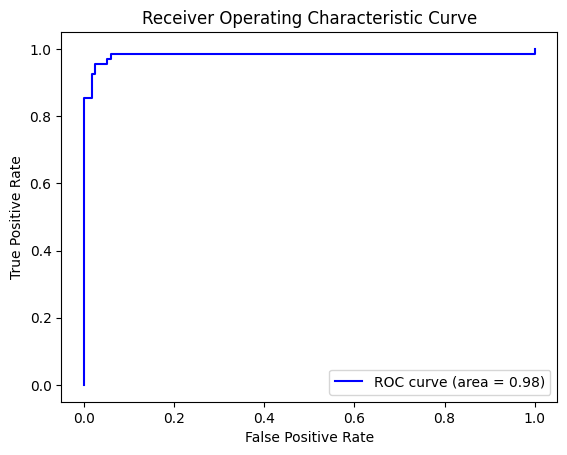

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import numpy as np

print("Random Forest Implementation\n\n")

# Initialize Spark session
spark = SparkSession.builder.appName("CancerDiagnosisRandomForest").getOrCreate()

# Load dataset
data = spark.read.csv('./project3_data.csv', header=True, inferSchema=True)

# Data preprocessing
labelIndexer = StringIndexer(inputCol="diagnosis", outputCol="indexeddiagnosis").fit(data)
featureCols = data.columns
featureCols.remove('diagnosis')
assembler = VectorAssembler(inputCols=featureCols, outputCol="features")
(trainData, testData) = data.randomSplit([0.7, 0.3])

# Define and train the model
rf = RandomForestClassifier(labelCol="indexeddiagnosis", featuresCol="features")
pipeline = Pipeline(stages=[labelIndexer, assembler, rf])
model = pipeline.fit(trainData)

# Make predictions
predictions = model.transform(testData)

# Evaluate accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="indexeddiagnosis", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)
print("Test Accuracy = %g" % accuracy)

# Evaluate additional metrics
f1_evaluator = MulticlassClassificationEvaluator(labelCol="indexeddiagnosis", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(predictions)
print("F1 Score = %g" % f1_score)

precision_evaluator = MulticlassClassificationEvaluator(labelCol="indexeddiagnosis", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)
print("Precision = %g" % precision)

recall_evaluator = MulticlassClassificationEvaluator(labelCol="indexeddiagnosis", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions)
print("Recall = %g" % recall)

# Plot ROC curve (for binary classification)
if data.select("diagnosis").distinct().count() == 2:
    binary_evaluator = BinaryClassificationEvaluator(labelCol="indexeddiagnosis")
    roc_auc = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: "areaUnderROC"})
    print("ROC AUC = %g" % roc_auc)

    # Assuming 'probability' is the column returned by model.transform()
    # which contains the probability predictions for each class
    probs = predictions.select("probability").rdd.map(lambda x: x[0][1]).collect()
    fpr, tpr, _ = roc_curve(predictions.select("indexeddiagnosis").collect(), probs)
    plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("ROC curve not plotted as the classification problem is not binary.")
